# IBM Data Science Professional Certificate - Capstone Project
by Thiago Figueira

Hello! 

This is the notebook with the solution for my capstone project for this Professional Certificate.

In this notebook, we will look at the following sections:

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 2>

1.  <a href="#item1">Introduction: Business Problem</a>

2.  <a href="#item2">Data Overview</a>

3.  <a href="#item3">Methodology</a>
    
4.  <a href="#item4">Visualizations</a>

5.  <a href="#item5">Results</a>
    
6.  <a href="#item6">Discussion</a>
    
7.  <a href="#item7">Conclusions</a>
    </font>
    </div>

## 1. Introduction: Business Problem <a class="anchor" id="item1"></a>

When moving to a new city, we face the problem of going into uncharted territory (at least, for us!). We want to choose a neighborhood that is secure, friendly, and close to what we need. Part of these requirements is fulfilled by the availability and proximity of core services, such as hospitals and schools. In this project, I will look at the neighborhoods of Manaus (in the state of Amazonas, Brazil) to determine which ones would be a nice place to live by looking at the count of available schools.

<figure style="text-aling: center">
    <img src="Images/theather1.jpg" alt="The Amazon Opera House in Manaus"/> 
    <figcaption>The Amazon Opera House in Manaus</figcaption>
</figure>

The main tools I will use are:
<ol>
    <li> Web-scrapping to acquire the data </li>
    <li> Geocode API to collect lat/long coordinates </li>
    <li> The Foursquare API to determine the number of schools in the vicinities </li>
    <li> Folium maps to visualize the region </li>
</ol>

In summary:

- This solution helps people looking to move to a neighborhood in Manaus find the one with the most number of schools available. It may also help the government understand which regions need more investment in the sector.
- The question we are answering is: which neighborhoods have the highest options regarding nearby schools?

## 2. Data Overview <a class="anchor" id="item2"></a>

The neighborhood dataset is available on this <a href="https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Manaus">Wikipedia page</a>. Let us have a look at it:

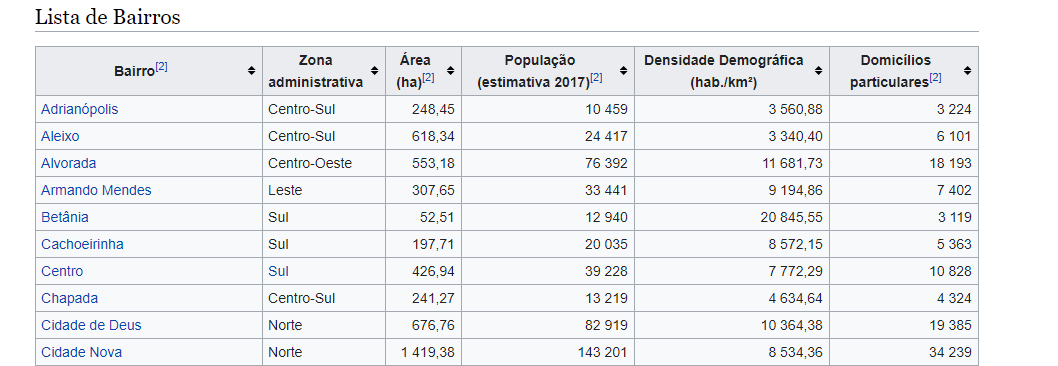

These are the first rows of the dataset. There is a total of 63 neighborhoods in Manaus. 

As you may have noticed, the data is in Portuguese, which is the native language of Brazil. Let us understand what each column represents in English:

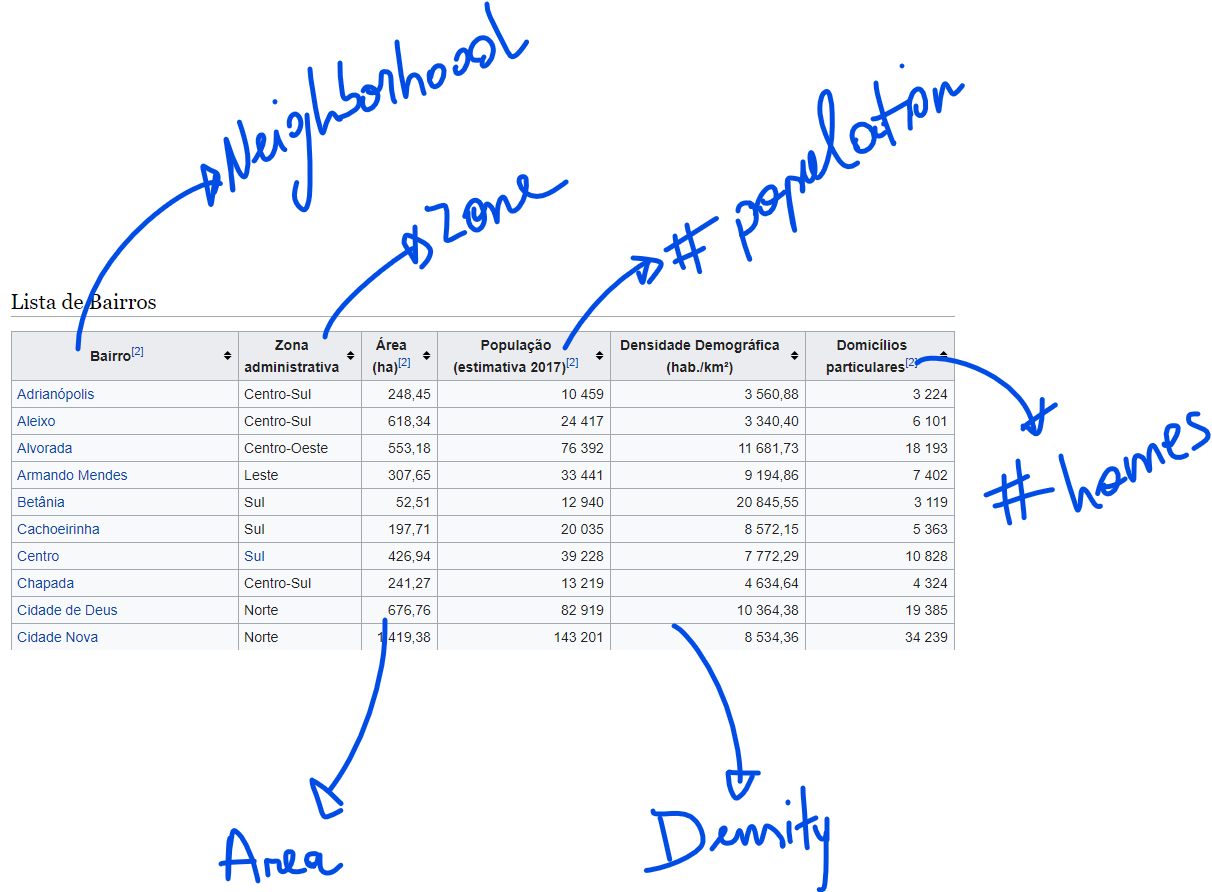

Notice neighborhoods are organized in zones (South, North, East, South-Center, etc.). Some are larger than others in total area size and in demographic density. In addition to the data available, we will need to collect latitude and longitude coordinates to feed to the Foursquare API.

## 3. Methodology <a class="anchor" id="item3"></a>

### 3.1 Data Collection

In [1]:
# Importing the required libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [112]:
# Download contents of the web page
url = "https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Manaus"
data = requests.get(url).text

In [113]:
# Create BeautifulSoup object
soup = BeautifulSoup(data, 'html.parser')

We now have the HTML of the page, so we need to find the table we want. We could retrieve the first table available, but there is the possibility the page contains more than one table, which is common in Wikipedia pages. For this reason, we have to look at all tables and find the correct one. Let us have a look at the structure of the HTML.

<figure style="text-aling: center">
    <img src="Images/tables.png" alt="HTML structure of the page"/> 
    <figcaption>HTML structure of the page</figcaption>
</figure>

Notice there is indeed more than one table. In the image above, the highlighted table is the one we want to collect. Unfortunately, the tables do not have a title, but they do have a class attribute. We can use this information to pick the correct table.

In [114]:
# Verify tables and their classes
print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))

Classes of each table:
['box-Desatualizado', 'plainlinks', 'metadata', 'ambox', 'ambox-content']
['wikitable', 'sortable']
['nowraplinks', 'collapsible', 'collapsed', 'navbox-inner']


From the image above, we understand we want the second table (aka. class = 'wikitable').

In [115]:
# Creating list with all tables
tables = soup.find_all('table')

#  We will look for the table with the 'wikitable' and 'sortable' classes. Notice that we do not need to use commas while passing the classes as parameters
table = soup.find('table', class_='wikitable sortable')

In [116]:
# Definition of the dataframe
df = pd.DataFrame(columns=['Neighborhood', 'Zone', 'Area', 'Population', 'Density', 'Homes_count'])

# Collect Ddata
for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    
    if(columns != []):
        neighborhood = columns[0].text.strip()
        zone = columns[1].text.strip()
        area = columns[2].span.contents[0].strip('&0.')
        population = columns[3].span.contents[0].strip('&0.')
        density = columns[4].span.contents[0].strip('&0.')
        homes_count = columns[5].span.contents[0].strip('&0.')

        df = df.append({'Neighborhood': neighborhood,  'Zone': zone, 'Area': area, 'Population': population, 'Density': density, 'Homes_count': homes_count}, ignore_index=True)

In [117]:
df.head()

,Neighborhood,Zone,Area,Population,Density,Homes_count
0,Adrianópolis,Centro-Sul,248.45,10459,3560.88,3224
1,Aleixo,Centro-Sul,618.34,24417,3340.4,6101
2,Alvorada,Centro-Oeste,553.18,76392,11681.73,18193
3,Armando Mendes,Leste,307.65,33441,9194.86,7402
4,Betânia,Sul,52.51,1294,20845.55,3119


We could have achieved the same result using the Pandas method *read_html*. This method returns a list of Dataframes containing html elements that satisfy our attribute specifications. For this case, we are looking for a class that contains the classes: wikitable and sortable. The *thousands* parameter specifies the separator used to parse thousands.

In [118]:
df_pandas = pd.read_html(url, attrs = {'class': 'wikitable sortable'},  flavor='bs4', thousands ='.')

In [119]:
df_pandas[0].head()

,Bairro[2],Zona administrativa,Área (ha)[2],População (estimativa 2017)[2],Densidade Demográfica (hab./km²),Domicílios particulares[2]
0,Adrianópolis,Centro-Sul,"248,45",10 459,"3 560,88",3 224
1,Aleixo,Centro-Sul,"618,34",24 417,"3 340,40",6 101
2,Alvorada,Centro-Oeste,"553,18",76 392,"11 681,73",18 193
3,Armando Mendes,Leste,"307,65",33 441,"9 194,86",7 402
4,Betânia,Sul,"52,51",12 940,"20 845,55",3 119


In [120]:
# Replacing long name to prevent error in the Nominatim API
df.replace('Praça 14 de Janeiro', 'Praça 14', inplace=True)

We collected our data!

### 3.2 Acquiring Latitude and Longitude values 

In [10]:
# Importing geolocation libraries
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [121]:
# Defining geolocator
locator = Nominatim(user_agent='foursquare_agent')
location = locator.geocode('Manaus, Amazonas')
print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))

# Storing Manaus' coordinates
manaus_latitude = location.latitude
manaus_longitude = location.longitude

Latitude = -3.1316333, Longitude = -59.9825041


We will create a column in the df to store the coordinates of each neighborhood. We will use *geopy rate limiter* which allows us to perform bulk operations while gracefully handling error responses and adding delays when needed. 

In [122]:
# Column with the whole address reference. We will feed this column to the geolocator
df['Full_Address'] = df['Neighborhood'].apply(lambda n: n + ', Manaus, Amazonas')

In [123]:
# Rate limiter definition
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

df['Full_Address'] = df['Neighborhood'].apply(lambda n: n + ', Manaus, Amazonas')

# Create location column
df['Location'] = df['Full_Address'].apply(geocode)

# Create longitude, laatitude and altitude from location column (returns tuple)
df['Point'] = df['Location'].apply(lambda loc: tuple(loc.point) if loc else None)

# Split point column into latitude, longitude and altitude columns
df[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df['Point'].tolist(), index=df.index)

In [124]:
# Checking the results
print(df.head())

     Neighborhood          Zone    Area Population   Density Homes_count  \
0    Adrianópolis    Centro-Sul  248.45      10459   3560.88        3224   
1          Aleixo    Centro-Sul  618.34      24417    3340.4        6101   
2        Alvorada  Centro-Oeste  553.18      76392  11681.73       18193   
3  Armando Mendes         Leste  307.65      33441   9194.86        7402   
4         Betânia           Sul   52.51       1294  20845.55        3119   

                       Full_Address  \
0    Adrianópolis, Manaus, Amazonas   
1          Aleixo, Manaus, Amazonas   
2        Alvorada, Manaus, Amazonas   
3  Armando Mendes, Manaus, Amazonas   
4         Betânia, Manaus, Amazonas   

                                            Location  \
0  (Adrianópolis, Manaus, Microrregião de Manaus,...   
1  (Aleixo, Manaus, Microrregião de Manaus, Regiã...   
2  (Alvorada, Manaus, Microrregião de Manaus, Reg...   
3  (Armando Mendes, Manaus, Microrregião de Manau...   
4  (Betânia, Manaus, Microrr

We will store the dataframe in a *.csv* file, so we do not have to rerun all cells everytime

In [128]:
# Saving current dataset to .csv file
df.to_csv('manaus_coordinates.csv', index=False)

### 3.3 Data Cleansing

In [388]:
# Load dataset from the file we saved previously
df = pd.read_csv('manaus_coordinates.csv')
df.head()

,Neighborhood,Zone,Area,Population,Density,Homes_count,Full_Address,Location,Point,Latitude,Longitude,Altitude
0,Adrianópolis,Centro-Sul,248.45,10459,3560.88,3224,"Adrianópolis, Manaus, Amazonas","Adrianópolis, Manaus, Microrregião de Manaus, ...","(-3.1016973, -60.0089746, 0.0)",-3.101697,-60.008975,0.0
1,Aleixo,Centro-Sul,618.34,24417,3340.40,6101,"Aleixo, Manaus, Amazonas","Aleixo, Manaus, Microrregião de Manaus, Região...","(-3.0872605, -59.9900635, 0.0)",-3.087261,-59.990063,0.0
2,Alvorada,Centro-Oeste,553.18,76392,11681.73,18193,"Alvorada, Manaus, Amazonas","Alvorada, Manaus, Microrregião de Manaus, Regi...","(-3.0758518, -60.0491264, 0.0)",-3.075852,-60.049126,0.0
3,Armando Mendes,Leste,307.65,33441,9194.86,7402,"Armando Mendes, Manaus, Amazonas","Armando Mendes, Manaus, Microrregião de Manaus...","(-3.0940003, -59.9432246, 0.0)",-3.094000,-59.943225,0.0
4,Betânia,Sul,52.51,1294,20845.55,3119,"Betânia, Manaus, Amazonas","Betânia, Manaus, Microrregião de Manaus, Regiã...","(-3.1330914, -59.9955771, 0.0)",-3.133091,-59.995577,0.0


Let us drop the columns that will not be used for this analysis.

In [389]:
df.drop(['Density', 'Homes_count', 'Location', 'Point', 'Altitude'], axis=1, inplace=True)
df.head()

,Neighborhood,Zone,Area,Population,Full_Address,Latitude,Longitude
0,Adrianópolis,Centro-Sul,248.45,10459,"Adrianópolis, Manaus, Amazonas",-3.101697,-60.008975
1,Aleixo,Centro-Sul,618.34,24417,"Aleixo, Manaus, Amazonas",-3.087261,-59.990063
2,Alvorada,Centro-Oeste,553.18,76392,"Alvorada, Manaus, Amazonas",-3.075852,-60.049126
3,Armando Mendes,Leste,307.65,33441,"Armando Mendes, Manaus, Amazonas",-3.094000,-59.943225
4,Betânia,Sul,52.51,1294,"Betânia, Manaus, Amazonas",-3.133091,-59.995577


We can proceed to our investigations!

### 3.4 Foursquare Investigations

In [390]:
# Tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Plotting library
import folium
from folium import plugins

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

In [391]:
# Define Foursquare credentials
CLIENT_ID = '5F2FTW0TV13AX3NHBI1JICTRC3TMJNPLCBOSBENZGCXUFUTE' # your Foursquare ID
CLIENT_SECRET = '0YTG43CDIA2QAO2CPLCX0MFZ4O52XTZ3MYQKS5GGBPFDP5AM' # your Foursquare Secret
ACCESS_TOKEN = 'ZIVPH02IJZYCT1Z3WR4GDETEOHGIEOPDBCC0SN2HHYU24UJT' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

Let us have a look at an example query:

In [392]:
address = 'Betânia, Manaus, Amazonas'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-3.1330914 -59.9955771


In [393]:
# Example query
search_query = 'school'
radius = 5000

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [394]:
#results = requests.get(url).json()['response']['venues']
#print(results)

In [395]:
def getNearbyVenues(names, latitudes, longitudes, search_query, radius=1000):
    
    '''
        This method searches the list of names for the given search query
        
        Returns:
        A dataframe containing venues that match the search params
    '''
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        print(name, lat, lng)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
        
        # make the GET request
        response = requests.get(url).json()
        results = response['response']['venues']
        
        # return only relevant information for each venue
        for v in results:
            v_name = v['name']
            v_lat = v['location']['lat']
            v_long = v['location']['lng']
            
            if (v['categories'] != []):
                v_cat = v['categories'][0]['name']
            else:
                v_cat = ''
            
            venues_list.append([(name, 
                                lat, 
                                lng,
                                v_name,
                                v_lat,
                                v_long,
                                v_cat)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [396]:
manaus_schools = getNearbyVenues(names = df['Neighborhood'],
                                 latitudes = df['Latitude'],
                                 longitudes = df['Longitude'],
                                 search_query = 'school')

Adrianópolis -3.1016973 -60.0089746
Aleixo -3.0872605 -59.9900635
Alvorada -3.0758518 -60.0491264
Armando Mendes -3.0940003 -59.9432246
Betânia -3.1330914 -59.9955771
Cachoeirinha -3.1252814 -60.0054165
Centro -3.1321038 -60.0215685
Chapada -3.0898329 -60.0271404
Cidade de Deus -3.0187172 -59.9504276
Cidade Nova -3.0299285 -59.9925943
Colônia Antônio Aleixo -3.1055488 -59.9051666
Colônia Oliveira Machado -3.1497072 -59.999752
Colônia Santo Antônio -0.9474148 -62.9450252
Colônia Terra Nova -3.0131364 -60.014594
Compensa -3.1052079 -60.0536927
Coroado -3.0901361 -59.9734359
Crespo -3.1338739 -59.9897549
Da Paz -3.0569693 -60.030696
Distrito Industrial I -3.1221754 -59.9601154
Distrito Industrial II -3.0429826 -59.9022483
Dom Pedro -3.0877436 -60.0431058
Educandos -3.1421444 -60.0110395
Flores -3.0568441 -60.0033342
Gilberto Mestrinho -3.0711282 -59.92669055948602
Glória -3.1185117 -60.0347041
Japiim -3.1132049 -59.9872376
Jorge Teixeira -3.0251198 -59.9268748
Lago Azul -2.9703847 -59.995

In [397]:
manaus_schools.shape

(69, 7)

In [398]:
manaus_schools.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adrianópolis,-3.101697,-60.008975,High School Ceme,-3.109498,-60.009820,Bar
1,Adrianópolis,-3.101697,-60.008975,C.e.s.a.r School,-3.106428,-60.012660,General College & University
2,Betânia,-3.133091,-59.995577,Galileo Business School,-3.133882,-59.990531,
3,Betânia,-3.133091,-59.995577,English Winner - School,-3.137728,-59.991000,University
4,Betânia,-3.133091,-59.995577,Galileo Business School,-3.125274,-59.995067,College Academic Building


### 3.5 Data Processing

Observe that even though some venues have the word *school* in the title, they actually belong to a category different than the one we want. Let us have a look at the values in this column

In [399]:
manaus_schools['Venue Category'].value_counts()

College Academic Building          14
Student Center                     10
School                              6
University                          6
High School                         5
                                    4
General College & University        4
Trade School                        4
Dance Studio                        3
College Communications Building     2
College Classroom                   2
Moving Target                       2
Language School                     1
Community College                   1
Office                              1
Design Studio                       1
Bar                                 1
College Arts Building               1
Private School                      1
Name: Venue Category, dtype: int64

In [400]:
# Remove categories that do not represent a school, including venues with empty categories
manaus_schools = manaus_schools[~manaus_schools['Venue Category'].isin(['Bar', 'Burger Joint', 'Skate Park', 'General Entertainment', 'Dance Studio', '', 'Moving Target'])]

In [401]:
manaus_schools['Venue Category'].value_counts()

College Academic Building          14
Student Center                     10
School                              6
University                          6
High School                         5
Trade School                        4
General College & University        4
College Communications Building     2
College Classroom                   2
College Arts Building               1
Community College                   1
Language School                     1
Office                              1
Private School                      1
Design Studio                       1
Name: Venue Category, dtype: int64

We should make sure there are no missing values in the coordinate columns:

In [402]:
manaus_schools.isnull().sum()

Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

In [403]:
print(manaus_schools[manaus_schools.isnull().any(axis=1)])

Empty DataFrame
Columns: [Neighborhood, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category]
Index: []


## 4. Visualizations <a class="anchor" id="item4"></a>

We will visualize the neighborhoods that have one or more schools in a radius less than 1 km

In [404]:
venues_map = folium.Map(location=[manaus_latitude, manaus_longitude], zoom_start=12, prefer_canvas=True) # generate map centered in Manaus

# add a red circle marker to represent the neighborhoods
for latitude, longitude, label in zip(manaus_schools['Neighborhood Latitude'], manaus_schools['Neighborhood Longitude'],  manaus_schools['Neighborhood']):
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label
    ).add_to(venues_map)

In [405]:
# display mapvenues_map
venues_map

Let us verify which neighborhood has the highest number of schools available

In [406]:
schools_count = manaus_schools.groupby(by='Neighborhood').size().sort_values(ascending=False)
print(schools_count)

Neighborhood
Centro                      9
Nossa Senhora das Graças    6
Praça 14                    5
São Geraldo                 4
Chapada                     4
Raiz                        3
Petrópolis                  3
Presidente Vargas           2
Cachoeirinha                2
Cidade Nova                 2
Crespo                      2
Dom Pedro                   2
Flores                      2
São Jorge                   2
Japiim                      2
Betânia                     2
Adrianópolis                1
São José Operário           1
São Lázaro                  1
Monte das Oliveiras         1
Morro da Liberdade          1
Glória                      1
São Raimundo                1
dtype: int64


In [419]:
# Number of neighborhoods without nearby schools
len(df['Neighborhood']) - len(schools_count)

40

In [407]:
df_most_schools = manaus_schools[manaus_schools['Neighborhood'] == schools_count.reset_index().loc[0, 'Neighborhood']]
df_most_schools

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Centro,-3.132104,-60.021569,GRACOM - School of Visual Effects,-3.134700,-60.022342,College Arts Building
8,Centro,-3.132104,-60.021569,GRACOM - School of Visual Effects,-3.133996,-60.021038,Design Studio
9,Centro,-3.132104,-60.021569,chicones school,-3.131810,-60.019302,College Academic Building
11,Centro,-3.132104,-60.021569,Infosystem school,-3.134800,-60.021700,Trade School
12,Centro,-3.132104,-60.021569,Gracom - School of Visual Effects,-3.134829,-60.022571,Office
13,Centro,-3.132104,-60.021569,UpFront School,-3.137767,-60.023256,College Academic Building
14,Centro,-3.132104,-60.021569,Liberal arts in english language school.,-3.125779,-60.019814,College Academic Building
15,Centro,-3.132104,-60.021569,Liberal arts in english language college.,-3.129084,-60.020089,College Academic Building
16,Centro,-3.132104,-60.021569,Centro Universitário do Norte - Uninorte - Uni...,-3.127646,-60.016036,College Academic Building


In [408]:
import html

In [409]:
venues_map = folium.Map(location=[manaus_latitude, manaus_longitude], zoom_start=12, prefer_canvas=True) # generate map centered in Manaus

# add the schools as blue circle markers
for lat, lng, label in zip(df_most_schools['Venue Latitude'], df_most_schools['Venue Longitude'], df_most_schools['Venue']):
    folium.CircleMarker(
        [lat, lng],
        icon=None,
        radius=5,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6,
        popup=html.escape(label)).add_to(venues_map)
    
venues_map

We can also look at all neighborhoods and schools combined in a single map

In [420]:
venues_map = folium.Map(location=[manaus_latitude, manaus_longitude], zoom_start=12, prefer_canvas=True) # generate map centered in Manaus

# add a red circle marker to represent the neighborhoods
for latitude, longitude, label in zip(manaus_schools['Neighborhood Latitude'], manaus_schools['Neighborhood Longitude'],  manaus_schools['Neighborhood']):
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label
    ).add_to(venues_map)
    
# add the schools as blue circle markers
for lat, lng, label in zip(manaus_schools['Venue Latitude'], manaus_schools['Venue Longitude'], manaus_schools['Venue']):
    folium.CircleMarker(
        [lat, lng],
        icon=None,
        radius=5,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6,
        popup=html.escape(label)).add_to(venues_map)
    
venues_map

## 5. Results <a class="anchor" id="item5"></a>

The main results are the answers to both questions asked initially. In other words, we accomplished our goal to use the data to find a small solution for real-world problems. There are a few possible improvements to the current approach: one of them is considering schools in the local language (escolas, in Portuguese). Another improvement could involve considering a custom radius depending on the size of each neighborhood.

## 6. Discussions <a class="anchor" id="item6"></a>

In the first map, we observe some neighborhoods lack nearby schools. In other words, students have to commute for more than 1 km in search of educational opportunities. We also notice most schools are located around downtown. In fact, the downtown neighborhood ('Centro') is the one with the most available schools. 

To answer the questions posed initially, the best neighborhoods to live in, if you want to move to Manaus and study in a nearby school, are close to the downtown. 
Besides, the government should establish a plan to increase the number of schools in the 40 neighborhoods lacking them.   

## 7. Conclusions <a class="anchor" id="item7"></a>

In this project, we

<ol>
    <li>Explored two ways to collect the data from the Wikipedia page</li>    
    <li>Identified the longitude and latitude coordinates for each neighborhood</li>  
    <li>Used the Foursquare API to identify nearby schools (at most 1 km distant)</li>  
    <li>Visualized which neighborhoods have nearby schools</li>
    <li>Visualized the neighborhood with the most number of nearby schools</li> 
    <li>Discussed the results</li> 
</ol>

Thanks for taking the time to look at this work. All the best!